In [154]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
from utils import *

# rootPath = "../../results/scenario/geothermal"
rootPath = "../../results/scenario/biogas"
# rootPath = "../../results/scenario/PHS"



plt.style.use('bmh')
%matplotlib inline

nBase = pypsa.Network("../../results/base/base27Node2045/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
nMean = pypsa.Network(rootPath + "-mean/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
nOptimist = pypsa.Network(rootPath + "-optimist/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
nBest = pypsa.Network(rootPath + "/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")



INFO:pypsa.io:Imported network base_s_27_lvopt_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_lvopt_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_lvopt_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_lvopt_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [156]:
include_biogas = True
include_Geothermie = False
include_warm = False
include_phs = False

def getDfValue(n):
  lists =  [
    # totla 3
    n.statistics.capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.expanded_capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_grouper").sum() / 1e9,
    # elec 10
    n.statistics.capex(groupby="de_generator_grouper").sum() / 1e9,
    n.statistics.expanded_capex(groupby="de_generator_grouper").sum() / 1e9,
    n.statistics.expanded_capex(groupby="de_generator_grouper").sum() / 1e9,
    n.statistics.optimal_capacity(groupby='de_generator_grouper').sum() / 1e3,
    n.statistics.supply(groupby='de_generator_grouper').sum() / 1e6,
    n.statistics.curtailment(groupby="de_generator_grouper").sum() / 1e6,
    n.statistics.optimal_capacity(groupby="de_import_elec_grouper").sum() / 1e3,
    n.statistics.supply(groupby="de_import_elec_grouper").sum() / 1e6,
    n.statistics.optimal_capacity(groupby="de_export_elec_grouper").sum() / 1e3,
    n.statistics.supply(groupby="de_export_elec_grouper").sum() / 1e6,    
  ]

  if include_warm:
    lists.extend([
      n.statistics.capex(groupby="de_heat_generator_grouper").sum() / 1e9,
      n.statistics.expanded_capex(groupby="de_heat_generator_grouper").sum() / 1e9,
      n.statistics.opex(groupby="de_heat_generator_grouper").sum() / 1e9,
      n.statistics.optimal_capacity(groupby='de_heat_generator_grouper').sum() / 1e3,
      n.statistics.supply(groupby="de_heat_generator_grouper").sum() / 1e6,
    ])

  if include_Geothermie:
    lists.extend([
      n.statistics.supply(groupby=["carrier", "de_generator_grouper"]).groupby('carrier').sum().get('geothermal organic rankine cycle', 0),
      renameHeatCarrier(n.statistics.supply(groupby=["carrier", "de_heat_generator_grouper"]).groupby('carrier').sum()).get('Geothermie', 0),
    ])
  
  if include_biogas:
    lists.extend([
      n.statistics.supply(groupby="de_biogas_generator_grouper").sum() /1e6,
      n.statistics.supply(groupby="de_gas_generator_grouper").sum() /1e6,
      n.statistics.supply(groupby="de_biogas_generator_grouper").sum()/n.statistics.supply(groupby="de_gas_generator_grouper").sum() * 100
    ])

  if include_phs:
    lists.extend([
      n.statistics.capex(groupby="de_phs_grouper").sum() /1e9,
      n.statistics.optimal_capacity(groupby="de_phs_grouper").sum() / 1e3,
      n.statistics.supply(groupby="de_phs_grouper").sum() /1e6,
    ])
  
  return lists

data = {
    'Name': [
       # total
      'CAPEX', 
      'investierte CAPEX', 
      'OPEX',
       # elec
      'Strom CAPEX',
      'Strom investierte CAPEX',
      'Strom OPEX',
      'Stromkapazität',
      'Stromerzeugung',
      'curtailment',
      'Importkapazität',
      'Importmenge',
      'Exportkapazität',
      'Exportmenge',
      ],
    'Unit': [
      # total
      'Mrd.EUR',
      'Mrd.EUR',
      'Mrd.EUR',
       # elec
      'Mrd.EUR',
      'Mrd.EUR',
      'Mrd.EUR',
      'GW',
      'TWH',
      'TWH',
      'GW',
      'TWH',
      'GW',
      'TWH',      
    ],
    'Base': getDfValue(nBase),
    'Mean': getDfValue(nMean),
    'Optimist': getDfValue(nOptimist),
    'Best': getDfValue(nBest)
}

if include_warm:
  data['Name'].extend([
    'Wärm CAPEX',
    'Wärm investierte CAPEX',
    'Wärm OPEX',
    'Wärmekapazität',
    'Wärmerzeugung',
  ])
  data['Unit'].extend([
    'Mrd.EUR',
    'Mrd.EUR',
    'Mrd.EUR',
    'GW',
    'TWH',     
  ])

if include_Geothermie:
  data['Name'].extend([
    'geothermal elec menge',
    'geothermal Wärm menge'
  ])
  data['Unit'].extend([
    'MWH',
    'MWH',
  ])

if include_biogas:
  data['Name'].extend([
    'Biogasproduktion',
    'Gasproduktion',
    'biogas/Gas'
  ])
  data['Unit'].extend([
    'MWH',
    'MWH',
    '%'
  ])
if include_phs:
  data['Name'].extend([
    'PHS CAPEX',
    'PHS Stromkapazität',
    'PHS Stromerzeugung '
  ])
  data['Unit'].extend([
    'Mrd.EUR',
    'GW',
    'TWH'
  ])

print(len(data['Name']), len(data['Unit']), len(data['Base']))

df = pd.DataFrame(data).set_index('Name')
table = dataframe_to_table(df)
print(table)

16 16 16
  [CAPEX], [Mrd.EUR], [64.255], [64.028], [63.843], [63.404],
  [investierte CAPEX], [Mrd.EUR], [44.917], [44.690], [44.506], [44.066],
  [OPEX], [Mrd.EUR], [6.631], [6.359], [6.199], [4.596],
  [Strom CAPEX], [Mrd.EUR], [26.205], [26.208], [26.206], [26.205],
  [Strom investierte CAPEX], [Mrd.EUR], [10.906], [10.909], [10.907], [10.906],
  [Strom OPEX], [Mrd.EUR], [10.906], [10.909], [10.907], [10.906],
  [Stromkapazität], [GW], [210.524], [210.581], [210.541], [210.520],
  [Stromerzeugung], [TWH], [589.774], [591.747], [590.517], [591.591],
  [curtailment], [TWH], [7.862], [5.943], [7.136], [6.041],
  [Importkapazität], [GW], [92.970], [92.971], [92.969], [92.969],
  [Importmenge], [TWH], [269.297], [269.466], [268.960], [269.263],
  [Exportkapazität], [GW], [98.193], [98.193], [98.191], [98.200],
  [Exportmenge], [TWH], [243.774], [243.702], [243.853], [243.614],
  [Biogasproduktion], [MWH], [30.621], [30.621], [30.621], [30.621],
  [Gasproduktion], [MWH], [56.809], [56.865

```
1 kW= 1e3 W               1 KWH = 1e3 WH             1 Tsd EUR = 1e3 EUR
1 MW = 1e6 W = 1 MW       1 MWH = 1e6 WH = 1 MWH     1 Mio.EUR = 1e6 EUR
1 GW = 1e9 W = 1e3 MW     1 GWH = 1e9 WH = 1e3 MWH   1 Mrd.EUR = 1e9 EUR
1 TW = 1e12 W = 1e6 MW    1 TWH = 1e12 WH = 1e6 MWH  1 Bio.EUR = 1e12 EUR


```

In [54]:
def de_elec_store_grouper(n, c):
  if (c == "StorageUnit"):
    df = n.df(c)
    return getIndexSeries(df, 
                      getIndexDeCarrier(df, 'PHS') | 
                      getIndexDeCarrier(df, 'hydro')
                      )
  if (c == 'Store'):
    df = n.df(c)
    return getIndexSeries(df,
                         getIndexDeCarrier(df, 'EV battery') | 
                         getIndexDeCarrier(df, 'battery') | 
                         getIndexDeCarrier(df, 'home battery')
                        )
  return getEmptyIndex()
pypsa.statistics.groupers.add_grouper("de_elec_store_grouper", de_elec_store_grouper)

/var/folders/v7/3zkz2x8x0gg0zyw7txxpwk380000gn/T/ipykernel_29774/3032307843.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storeStoreDf[storeStoreDf<0]=0
/var/folders/v7/3zkz2x8x0gg0zyw7txxpwk380000gn/T/ipykernel_29774/3032307843.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storeStoreDf[storeStoreDf<0]=0
/var/folders/v7/3zkz2x8x0gg0zyw7txxpwk380000gn/T/ipykernel_29774/3032307843.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<Axes: xlabel='snapshot'>

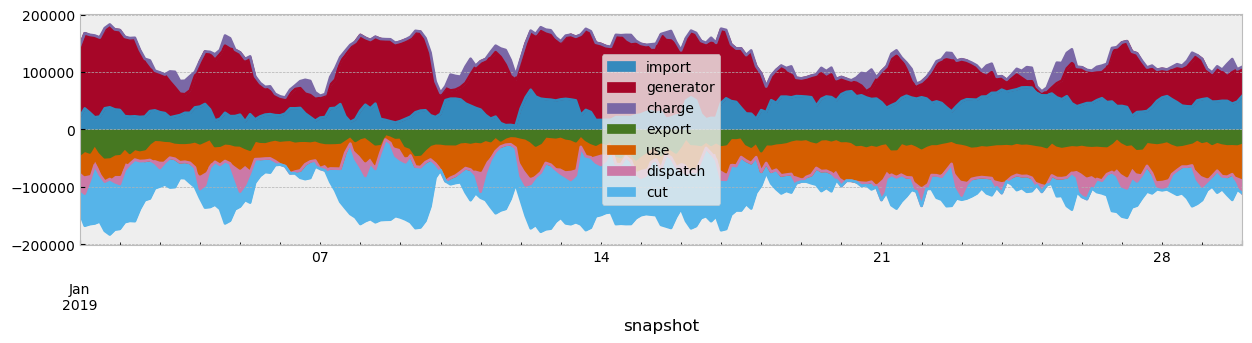

In [153]:
n = nBase

df = pd.DataFrame(index = n.snapshots)

importLinkIds = de_import_elec_grouper(n, 'Link').tolist()
importLinIds = de_import_elec_grouper(n, 'Line').tolist()
df['import'] = n.links_t.p1[importLinkIds].abs().sum(axis=1) \
  + n.lines_t.p1[importLinIds].abs().sum(axis=1)

generatorGeneratorIds =  de_generator_grouper(n, 'Generator').tolist()
generatorLinkIds =  de_generator_grouper(n, 'Link').tolist()
df['generator'] =  n.generators_t.p[generatorGeneratorIds].sum(axis=1) \
  + n.links_t.p1[generatorLinkIds].abs().sum(axis=1)

storeStorageIds = de_elec_store_grouper(n, 'StorageUnit').tolist()
storeStoreIds = de_elec_store_grouper(n, 'Store').tolist()
storeStoreDf =n.stores_t.p[storeStoreIds]
storeStoreDf[storeStoreDf<0]=0
storeStoreDf
df['charge'] = n.storage_units_t.p_dispatch[storeStorageIds].sum(axis=1)\
  + storeStoreDf.sum(axis=1)


# use
exportLinkIds = de_export_elec_grouper(n, 'Link').tolist()
exportLinIds = de_export_elec_grouper(n, 'Line').tolist()
df['export'] = n.links_t.p1[exportLinkIds].abs().sum(axis=1) \
  + n.lines_t.p1[exportLinIds].abs().sum(axis=1)
df['export'] = - df['export']

useLinkIds = de_elec_use_grouper(n, 'Link').tolist()
useLoadIds = de_elec_use_grouper(n, 'Load').tolist()
df['use'] = n.links_t.p1[importLinkIds].abs().sum(axis=1) \
  + n.loads_t.p[useLoadIds].sum(axis=1)
df['use'] = - df['use']

storeStorageIds = de_elec_store_grouper(n, 'StorageUnit').tolist()
storeStoreIds = de_elec_store_grouper(n, 'Store').tolist()
storeStoreDf =n.stores_t.p[storeStoreIds]
storeStoreDf[storeStoreDf>0]=0
storeStoreDf
df['dispatch'] = n.storage_units_t.p_store[storeStorageIds].sum(axis=1)\
  + storeStoreDf.abs().sum(axis=1)
df['dispatch'] = - df['dispatch']


total_use = (df['export'] + df['use'] + df['dispatch'])
total_produce= (df['import'] + df['generator'] + df['charge'])

df['cut'] = total_use + total_produce
df['cut'][df['cut']<0]=0
df['cut'] = - df['cut']
# 
#  + (df['import'] + df['generator'] + df['charge'])
# df['cut'][df['cut'] > 0] = 0



df['2019-01-01 00:00:00': '2019-01-30 00:00:00'].plot(kind='area', figsize=(15,3))

In [139]:
df['cut'].sum()

109189536.19071606

/var/folders/v7/3zkz2x8x0gg0zyw7txxpwk380000gn/T/ipykernel_29774/296172896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storeStoreDf[storeStoreDf>0]=0
/var/folders/v7/3zkz2x8x0gg0zyw7txxpwk380000gn/T/ipykernel_29774/296172896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storeStoreDf[storeStoreDf>0]=0


<Axes: xlabel='snapshot'>

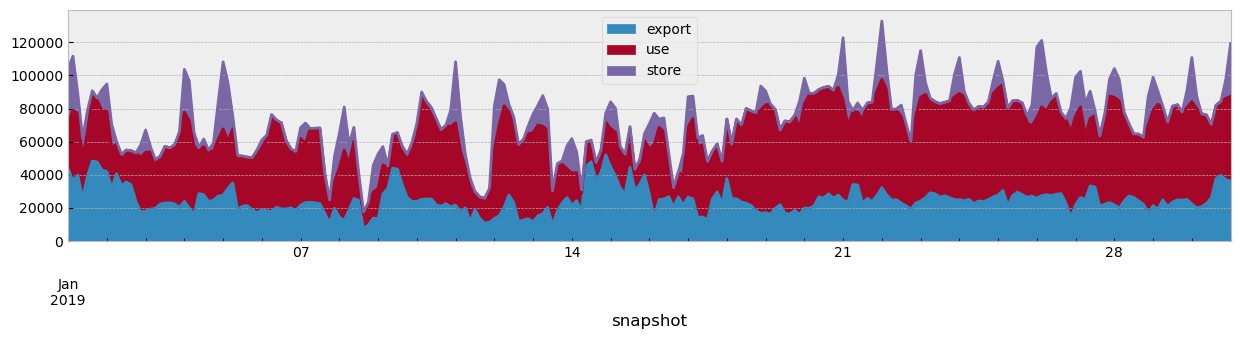

In [130]:
n = nBase

df = pd.DataFrame(index = n.snapshots)

exportLinkIds = de_export_elec_grouper(n, 'Link').tolist()
exportLinIds = de_export_elec_grouper(n, 'Line').tolist()
df['export'] = n.links_t.p1[exportLinkIds].abs().sum(axis=1) \
  + n.lines_t.p1[exportLinIds].abs().sum(axis=1)

useLinkIds = de_elec_use_grouper(n, 'Link').tolist()
useLoadIds = de_elec_use_grouper(n, 'Load').tolist()
df['use'] = n.links_t.p1[importLinkIds].abs().sum(axis=1) \
  + n.loads_t.p[useLoadIds].sum(axis=1)



storeStorageIds = de_elec_store_grouper(n, 'StorageUnit').tolist()
storeStoreIds = de_elec_store_grouper(n, 'Store').tolist()
storeStoreDf =n.stores_t.p[storeStoreIds]
storeStoreDf[storeStoreDf>0]=0
storeStoreDf
df['store'] = n.storage_units_t.p_store[storeStorageIds].sum(axis=1)\
  + storeStoreDf.abs().sum(axis=1)
df

df['2019-01-01 00:00:00': '2019-01-31 00:00:00'].plot(kind='area', figsize=(15,3))

In [114]:
n.loads_t.p['DE0 0 industry electricity']

snapshot
2019-01-01 00:00:00   4697.48858
2019-01-01 03:00:00   4697.48858
2019-01-01 06:00:00   4697.48858
2019-01-01 09:00:00   4697.48858
2019-01-01 12:00:00   4697.48858
2019-01-01 15:00:00   4697.48858
2019-01-01 18:00:00   4697.48858
2019-01-01 21:00:00   4697.48858
2019-01-02 00:00:00   4697.48858
2019-01-02 03:00:00   4697.48858
2019-01-02 06:00:00   4697.48858
2019-01-02 09:00:00   4697.48858
2019-01-02 12:00:00   4697.48858
2019-01-02 15:00:00   4697.48858
2019-01-02 18:00:00   4697.48858
2019-01-02 21:00:00   4697.48858
2019-01-03 00:00:00   4697.48858
2019-01-03 03:00:00   4697.48858
2019-01-03 06:00:00   4697.48858
2019-01-03 09:00:00   4697.48858
2019-01-03 12:00:00   4697.48858
2019-01-03 15:00:00   4697.48858
2019-01-03 18:00:00   4697.48858
2019-01-03 21:00:00   4697.48858
2019-01-04 00:00:00   4697.48858
2019-01-04 03:00:00   4697.48858
2019-01-04 06:00:00   4697.48858
2019-01-04 09:00:00   4697.48858
2019-01-04 12:00:00   4697.48858
2019-01-04 15:00:00   4697.48858
2

In [129]:
def de_elec_use_grouper(n,c):
  if (c == 'Load'):
    df = n.df(c)
    return getIndexSeries(df,
                          getIndexDeCarrier(df, 'agriculture electricity') |
                          getIndexDeCarrier(df, 'electricity') |
                          getIndexDeCarrier(df, 'industry electricity')  
                          )
  if (c == 'Link'):
    df = n.df(c)
    return getIndexSeries(df,
                          getIndexDeCarrier(df, 'urban central air heat pump') |
                          getIndexDeCarrier(df, 'urban central resistive heater') |
                          getIndexDeCarrier(df, 'rural air heat pump') |
                          getIndexDeCarrier(df, 'rural ground heat pump') |
                          getIndexDeCarrier(df, 'rural resistive heater') |
                          getIndexDeCarrier(df, 'urban decentral air heat pump') |
                          getIndexDeCarrier(df, 'urban decentral resistive heater') |
                          getIndexDeCarrier(df, 'urban decentral resistive heater') |
                          getIndexDeCarrier(df, 'DAC') 
                          )
  return getEmptyIndex()